# Train Reinforcement Learning Agent

In [1]:
# Stable-Baselines3 and Gymnasium Implementation
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import os

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import os

# Add this to your imports cell
import torch
import torch.nn as nn
# Import our functions
from main import updated_fisher_information, reward_function

### Create Enviornment

In [2]:
class QuantumNetworkEnv(gym.Env):
    """
    Gymnasium Environment for Quantum Network Protocol Selection
    
    The agent receives theta values and current Fisher information, then selects
    protocols to maximize cumulative reward over multiple steps.
    """
    
    metadata = {'render_modes': ['human', 'rgb_array'], 'render_fps': 4}
    
    def __init__(self, max_steps=10, render_mode=None):
        super().__init__()
        
        self.max_steps = max_steps
        self.render_mode = render_mode
        self.step_count = 0
        
        # Action space: Combined root (3 options) and protocol (6 options) selection
        # Total actions = 3 roots × 6 protocols = 18 possible actions
        # Action encoding: action = root * 6 + protocol
        # Where root ∈ {0, 1, 2} and protocol ∈ {0, 1, 2, 3, 4, 5}
        self.action_space = spaces.Discrete(18)
        
        # Observation space: Flattened Fisher matrix (3x3 = 9 values) + theta parameters (3 values)
        # Total observation size: 9 + 3 = 12 values
        # Fisher matrix values: -10 to 100, Theta values: 0.05 to 0.45
        self.observation_space = spaces.Box(
            low=np.array([-10.0] * 9 + [0.05] * 3, dtype=np.float32),  # 9 Fisher + 3 theta
            high=np.array([100.0] * 9 + [0.45] * 3, dtype=np.float32),  # 9 Fisher + 3 theta
            dtype=np.float32
        )
        
        # Initialize state variables
        self.theta = None
        self.fisher_matrix = None
        self.total_reward = 0
        self.episode_history = []
        
    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)
        
        if seed is not None:
            np.random.seed(seed)
        
        self.step_count = 0
        self.total_reward = 0
        self.episode_history = []
        
        # Initialize theta values randomly
        self.theta = [np.random.uniform(0.05, 0.45) for _ in range(3)]
        
        # Initialize Fisher matrix to zeros (3x3)
        self.fisher_matrix = np.zeros((3, 3), dtype=np.float32)
        
        observation = self._get_observation()
        info = self._get_info()
        
        return observation, info
    
    def step(self, action):
        """Execute one step in the environment"""
        if not self.action_space.contains(action):
            raise ValueError(f"Invalid action: {action}. Must be in {self.action_space}")
        
        # Decode the combined action into root and protocol
        # action = root * 6 + protocol
        root = action // 6  # Integer division to get root (0, 1, or 2)
        protocol = action % 6  # Modulo to get protocol (0, 1, 2, 3, 4, 5)
        
        # Store old fisher matrix for analysis
        old_fisher_matrix = self.fisher_matrix.copy()
        
        try:
            # Update Fisher information using the selected root and protocol
            new_fisher_matrix = updated_fisher_information(root, protocol, self.theta)
            
            # Add new contribution to existing Fisher matrix
            self.fisher_matrix += new_fisher_matrix
            
            # Calculate reward using the updated Fisher matrix
            reward = reward_function(self.fisher_matrix)
            
        except ZeroDivisionError:
            # Handle edge case where theta values cause division by zero
            reward = -10.0  # Penalty for invalid state
            new_fisher_matrix = np.zeros((3, 3), dtype=np.float32)
        
        self.total_reward += reward
        self.step_count += 1
        
        # Check if episode is done
        terminated = self.step_count >= self.max_steps
        truncated = False  # We don't have time limits beyond max_steps
        

        # Store step information for analysis
        step_info = {
            'step': self.step_count,
            'action': action,
            'root': root,
            'protocol': protocol,
            'reward': reward,
            'fisher_matrix': self.fisher_matrix.copy(),
            'fisher_contribution': new_fisher_matrix.copy(),
            'theta': self.theta.copy()
        }
        self.episode_history.append(step_info)
        
        observation = self._get_observation()
        info = self._get_info()
        info.update(step_info)
        
        return observation, reward, terminated, truncated, info
    
    def _get_observation(self):
        """Get current observation: flattened Fisher matrix (9 values) + theta parameters (3 values)"""
        # Flatten the 3x3 Fisher matrix to a 1D array
        fisher_flat = self.fisher_matrix.flatten()
        
        # Combine flattened Fisher matrix with theta parameters
        obs = np.concatenate([fisher_flat, self.theta], dtype=np.float32)
        
        # Clip to ensure it's within observation space bounds
        return np.clip(obs, self.observation_space.low, self.observation_space.high)
    
    def _get_info(self):
        """Get additional information about the current state"""
        return {
            'step_count': self.step_count,
            'total_reward': self.total_reward,
            'theta': self.theta.copy(),
            'fisher_matrix': self.fisher_matrix.copy(),
            'fisher_diagonal': np.diag(self.fisher_matrix).copy()
        }
    
    def decode_action(self, action):
        """Decode combined action into root and protocol"""
        root = action // 6
        protocol = action % 6
        return root, protocol
    
    def encode_action(self, root, protocol):
        """Encode root and protocol into combined action"""
        return root * 6 + protocol
    
    def render(self):
        """Render the environment (optional)"""
        if self.render_mode == 'human':
            print(f"Step: {self.step_count}/{self.max_steps}")
            print(f"Theta: {[f'{x:.3f}' for x in self.theta]}")
            print(f"Fisher Matrix Diagonal: {[f'{x:.3f}' for x in np.diag(self.fisher_matrix)]}")
            print(f"Fisher Matrix Trace: {np.trace(self.fisher_matrix):.3f}")
            print(f"Total Reward: {self.total_reward:.3f}")
            print("-" * 40)
    
    def close(self):
        """Clean up environment"""
        pass

### Test Enviornemnt

In [3]:
# Create and test the environment with updated action space
print("Creating Quantum Network Environment with Root + Protocol Selection...")
env = QuantumNetworkEnv(max_steps=10)

# Check if the environment follows Gymnasium API
print("Checking environment...")
try:
    check_env(env, warn=True)
    print("Environment check passed!")
except Exception as e:
    print(f"Environment check failed: {e}")

# Test the environment
print("\nTesting environment reset...")
obs, info = env.reset(seed=42)
print(f"Initial observation shape: {obs.shape}")
print(f"Initial observation: {obs}")
print(f"Action space: {env.action_space} (18 total actions)")
print(f"Observation space: {env.observation_space}")

# Demonstrate action encoding
print("\nAction Encoding Examples:")
print("Action = Root * 6 + Protocol")
for root in range(3):
    for protocol in range(6):
        encoded_action = env.encode_action(root, protocol)
        decoded_root, decoded_protocol = env.decode_action(encoded_action)
        print(f"Root {root}, Protocol {protocol} → Action {encoded_action}")
print()

# Test a few random steps with detailed output
print("Testing random steps with root and protocol details...")
for i in range(3):
    action = env.action_space.sample()
    root, protocol = env.decode_action(action)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step {i+1}: Action={action} (Root={root}, Protocol={protocol}), Reward={reward:.3f}, Done={terminated}")
    
env.close()
print("Environment test completed successfully! ✓")

Creating Quantum Network Environment with Root + Protocol Selection...
Checking environment...
Environment check failed: The reward returned by `step()` must be a float

Testing environment reset...
Initial observation shape: (12,)
Initial observation: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.19981605 0.43028572 0.34279758]
Action space: Discrete(18) (18 total actions)
Observation space: Box([-10.   -10.   -10.   -10.   -10.   -10.   -10.   -10.   -10.     0.05
   0.05   0.05], [100.   100.   100.   100.   100.   100.   100.   100.   100.     0.45
   0.45   0.45], (12,), float32)

Action Encoding Examples:
Action = Root * 6 + Protocol
Root 0, Protocol 0 → Action 0
Root 0, Protocol 1 → Action 1
Root 0, Protocol 2 → Action 2
Root 0, Protocol 3 → Action 3
Root 0, Protocol 4 → Action 4
Root 0, Protocol 5 → Action 5
Root 1, Protocol 0 → Action 6
Root 1, Protocol 1 → Action 7
Root 1, Protocol 2 → Action 8
Root 1, Protocol 3 → Action 9
Roo

### Create RL Agent

In [7]:
# Train a PPO agent using Stable-Baselines3

print("Setting up training environment...")

# Create training and evaluation environments
train_env = QuantumNetworkEnv(max_steps=20)
eval_env = QuantumNetworkEnv(max_steps=20)

# Wrap environments with Monitor for logging
train_env = Monitor(train_env)
eval_env = Monitor(eval_env)

# Create the PPO model
print("Creating PPO model...")
# Better hyperparameters for improved learning
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=5e-5,  # Reduced learning rate
    n_steps=4096,        # More steps per update
    batch_size=256,      # Larger batch size
    n_epochs=20,         # More epochs per update
    gamma=0.95,          # Slightly reduced discount factor
    gae_lambda=0.9,      # Reduced GAE lambda
    clip_range=0.1,      # Tighter clipping
    ent_coef=0.05,       # More exploration
    vf_coef=0.5,         # Value function coefficient
    max_grad_norm=0.5,   # Gradient clipping
    policy_kwargs=dict(
        net_arch=[128, 128, 64],  # Deeper network
        activation_fn=torch.nn.ReLU
    ),
    device="cpu",
    tensorboard_log="./ppo_protocol_picker_logs/"
)

print("Model created successfully!")
print(f"Policy architecture: {model.policy}")

# Create evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_protocol_picker/",
    log_path="./protocol_picker_eval_logs/",
    eval_freq=1000,
    deterministic=True,
    render=False,
    verbose=1
)

print("Training setup completed! Ready to train the agent.")

Setting up training environment...
Creating PPO model...
Using cpu device
Wrapping the env in a DummyVecEnv.
Model created successfully!
Policy architecture: ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=

### Train the RL agent

In [15]:
# Train the model
print("Starting training...")
print("Training for 10,000 timesteps (adjust as needed)")

# Train the model
model.learn(
    total_timesteps=1_000_000,
    callback=eval_callback,
    tb_log_name="PPO_QuantumNetwork",
    #progress_bar=True
)

print("Training completed!")

# Save the final model
model.save("protocol_picker_agents/quantum_network_ppo_final")
print("Model saved as 'quantum_network_ppo_final'")

# Load and test the trained model
print("\nTesting the trained model...")
trained_model = PPO.load("protocol_picker_agents/quantum_network_ppo_final")

# Test on a few episodes with detailed action analysis
test_env = QuantumNetworkEnv(max_steps=10)
total_rewards = []

for episode in range(5):
    obs, info = test_env.reset(seed=episode)
    episode_reward = 0
    episode_actions = []
    episode_details = []
    
    for step in range(10):
        action, _states = trained_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)
        episode_reward += reward
        episode_actions.append(action)
        
        # Decode action for detailed analysis
        root, protocol = test_env.decode_action(action)
        episode_details.append(f"R{root}P{protocol}")
        
        if terminated or truncated:
            break
    
    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward:.3f}")
    print(f"  Actions = {episode_actions}")
    print(f"  Details = {episode_details}")

average_reward = np.mean(total_rewards)
print(f"\nAverage reward over 5 test episodes: {average_reward:.3f}")
test_env.close()

Starting training...
Training for 10,000 timesteps (adjust as needed)
Logging to ./ppo_protocol_picker_logs/PPO_QuantumNetwork_4
Eval num_timesteps=216, episode_reward=46.84 +/- 12.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.8     |
| time/              |          |
|    total_timesteps | 216      |
---------------------------------
Eval num_timesteps=216, episode_reward=46.84 +/- 12.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.8     |
| time/              |          |
|    total_timesteps | 216      |
---------------------------------
Eval num_timesteps=1216, episode_reward=35.10 +/- 7.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.1     |
|

In [16]:
! tensorboard --logdir=./ppo_protocol_picker_logs/ --port=6006


Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
^C


### Evaluate Model

In [23]:
# Load and simulate trained RL agent on network with theta=[0.1, 0.2, 0.3]

class FixedThetaQuantumEnv(QuantumNetworkEnv):
    """
    Special environment with fixed theta values for testing
    """
    def __init__(self, theta_values, max_steps=10):
        super().__init__(max_steps=max_steps)
        self.fixed_theta = theta_values
        
    def reset(self, seed=None, options=None):
        """Reset with fixed theta values"""
        super().reset(seed=seed)
        self.theta = self.fixed_theta.copy()  # Use fixed theta values
        observation = self._get_observation()
        info = self._get_info()
        return observation, info

print("Loading Trained RL Agent and Simulating on theta=[0.1, 0.2, 0.3]")
print("=" * 70)

# Load the trained model
try:
    trained_model = PPO.load("protocol_picker_agents/quantum_network_ppo_final")
    print("Successfully loaded trained PPO model!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure you've trained and saved the model first.")
    trained_model = None

if trained_model is not None:
    # Create environment with fixed theta values
    test_theta = [0.1, 0.2, 0.3]
    sim_env = FixedThetaQuantumEnv(theta_values=test_theta, max_steps=10)
    
    print(f"\nQuantum Network Configuration:")
    print(f"   Theta values: {test_theta}")
    print(f"   Max steps: 10")
    print(f"   Action space: 18 (3 roots × 6 protocols)")
    
    # Run simulation
    print(f"\n Starting Simulation...")
    print("-" * 50)
    
    obs, info = sim_env.reset(seed=42)
    episode_data = []
    total_reward = 0
    
    print(f"Initial State:")
    print(f"  Theta: {sim_env.theta}")
    print(f"  Fisher Matrix Diagonal: {np.diag(sim_env.fisher_matrix)}")
    print(f"  Fisher Matrix Trace: {np.trace(sim_env.fisher_matrix):.3f}")
    print(f"  Observation Shape: {obs.shape}")
    print()
    
    # Run 10 steps
    for step in range(10):
        # Get action from trained agent
        action, _states = trained_model.predict(obs, deterministic=True)
        
        # Decode action
        root, protocol = sim_env.decode_action(action)
        
        # Take step
        obs, reward, terminated, truncated, info = sim_env.step(action)
        total_reward += reward
        
        # Store step data
        step_data = {
            'step': step + 1,
            'action': action,
            'root': root,
            'protocol': protocol,
            'reward': reward,
            'fisher_contribution': info['fisher_contribution'],
            'fisher_matrix': info['fisher_matrix'],
            'total_reward': total_reward
        }
        episode_data.append(step_data)
        
        # Print step details
        print(f"Step {step + 1}:")
        print(f"  Action: {action} → Root {root}, Protocol {protocol}")
        print(f"  Reward: {reward:.4f}")
        print(f"  Fisher Contribution Diagonal: [{np.diag(info['fisher_contribution'])[0]:.3f}, {np.diag(info['fisher_contribution'])[1]:.3f}, {np.diag(info['fisher_contribution'])[2]:.3f}]")
        print(f"  Cumulative Fisher Diagonal:   [{np.diag(info['fisher_matrix'])[0]:.3f}, {np.diag(info['fisher_matrix'])[1]:.3f}, {np.diag(info['fisher_matrix'])[2]:.3f}]")
        print(f"  Total Reward: {total_reward:.4f}")
        print()
        
        if terminated or truncated:
            break
    
    # Final Analysis
    print("SIMULATION SUMMARY")
    print("=" * 50)
    print(f"Final Total Reward: {total_reward:.4f}")
    print(f"Final Fisher Matrix Diagonal: [{np.diag(sim_env.fisher_matrix)[0]:.3f}, {np.diag(sim_env.fisher_matrix)[1]:.3f}, {np.diag(sim_env.fisher_matrix)[2]:.3f}]")
    print(f"Final Fisher Matrix Trace: {np.trace(sim_env.fisher_matrix):.3f}")
    
    # Calculate balance metrics
    final_fisher = np.diag(sim_env.fisher_matrix)
    mean_fisher = np.mean(final_fisher)
    variance_fisher = np.var(final_fisher)
    cv = np.sqrt(variance_fisher) / mean_fisher if mean_fisher > 0 else 0
    
    print(f"Mean Fisher Information: {mean_fisher:.3f}")
    print(f"Fisher Info Variance: {variance_fisher:.3f}")
    print(f"Coefficient of Variation: {cv:.3f}")
    
    # Action selection analysis
    roots_used = [data['root'] for data in episode_data]
    protocols_used = [data['protocol'] for data in episode_data]
    
    print(f"\nAgent Strategy Analysis:")
    print(f"Root selection frequency:")
    for root in range(3):
        count = roots_used.count(root)
        print(f"  Root {root}: {count}/10 times ({count*10}%)")
    
    print(f"Protocol selection frequency:")
    for protocol in range(6):
        count = protocols_used.count(protocol)
        print(f"  Protocol {protocol}: {count}/10 times ({count*10}%)")
    
    # Most frequent combinations
    combinations = [(data['root'], data['protocol']) for data in episode_data]
    unique_combinations = list(set(combinations))
    print(f"\nRoot-Protocol combinations used:")
    for combo in unique_combinations:
        count = combinations.count(combo)
        print(f"  R{combo[0]}P{combo[1]}: {count} times")
    
    sim_env.close()
    print("\n✓ Simulation completed successfully!")

Loading Trained RL Agent and Simulating on theta=[0.1, 0.2, 0.3]
Successfully loaded trained PPO model!

Quantum Network Configuration:
   Theta values: [0.1, 0.2, 0.3]
   Max steps: 10
   Action space: 18 (3 roots × 6 protocols)

 Starting Simulation...
--------------------------------------------------
Initial State:
  Theta: [0.1, 0.2, 0.3]
  Fisher Matrix Diagonal: [0. 0. 0.]
  Fisher Matrix Trace: 0.000
  Observation Shape: (12,)

Step 1:
  Action: 5 → Root 0, Protocol 5
  Reward: 2.4941
  Fisher Contribution Diagonal: [11.111, 0.000, 0.000]
  Cumulative Fisher Diagonal:   [11.111, 0.000, 0.000]
  Total Reward: 2.4941

Step 2:
  Action: 5 → Root 0, Protocol 5
  Reward: 3.1451
  Fisher Contribution Diagonal: [11.111, 0.000, 0.000]
  Cumulative Fisher Diagonal:   [22.222, 0.000, 0.000]
  Total Reward: 5.6392

Step 3:
  Action: 5 → Root 0, Protocol 5
  Reward: 3.5361
  Fisher Contribution Diagonal: [11.111, 0.000, 0.000]
  Cumulative Fisher Diagonal:   [33.333, 0.000, 0.000]
  Total 

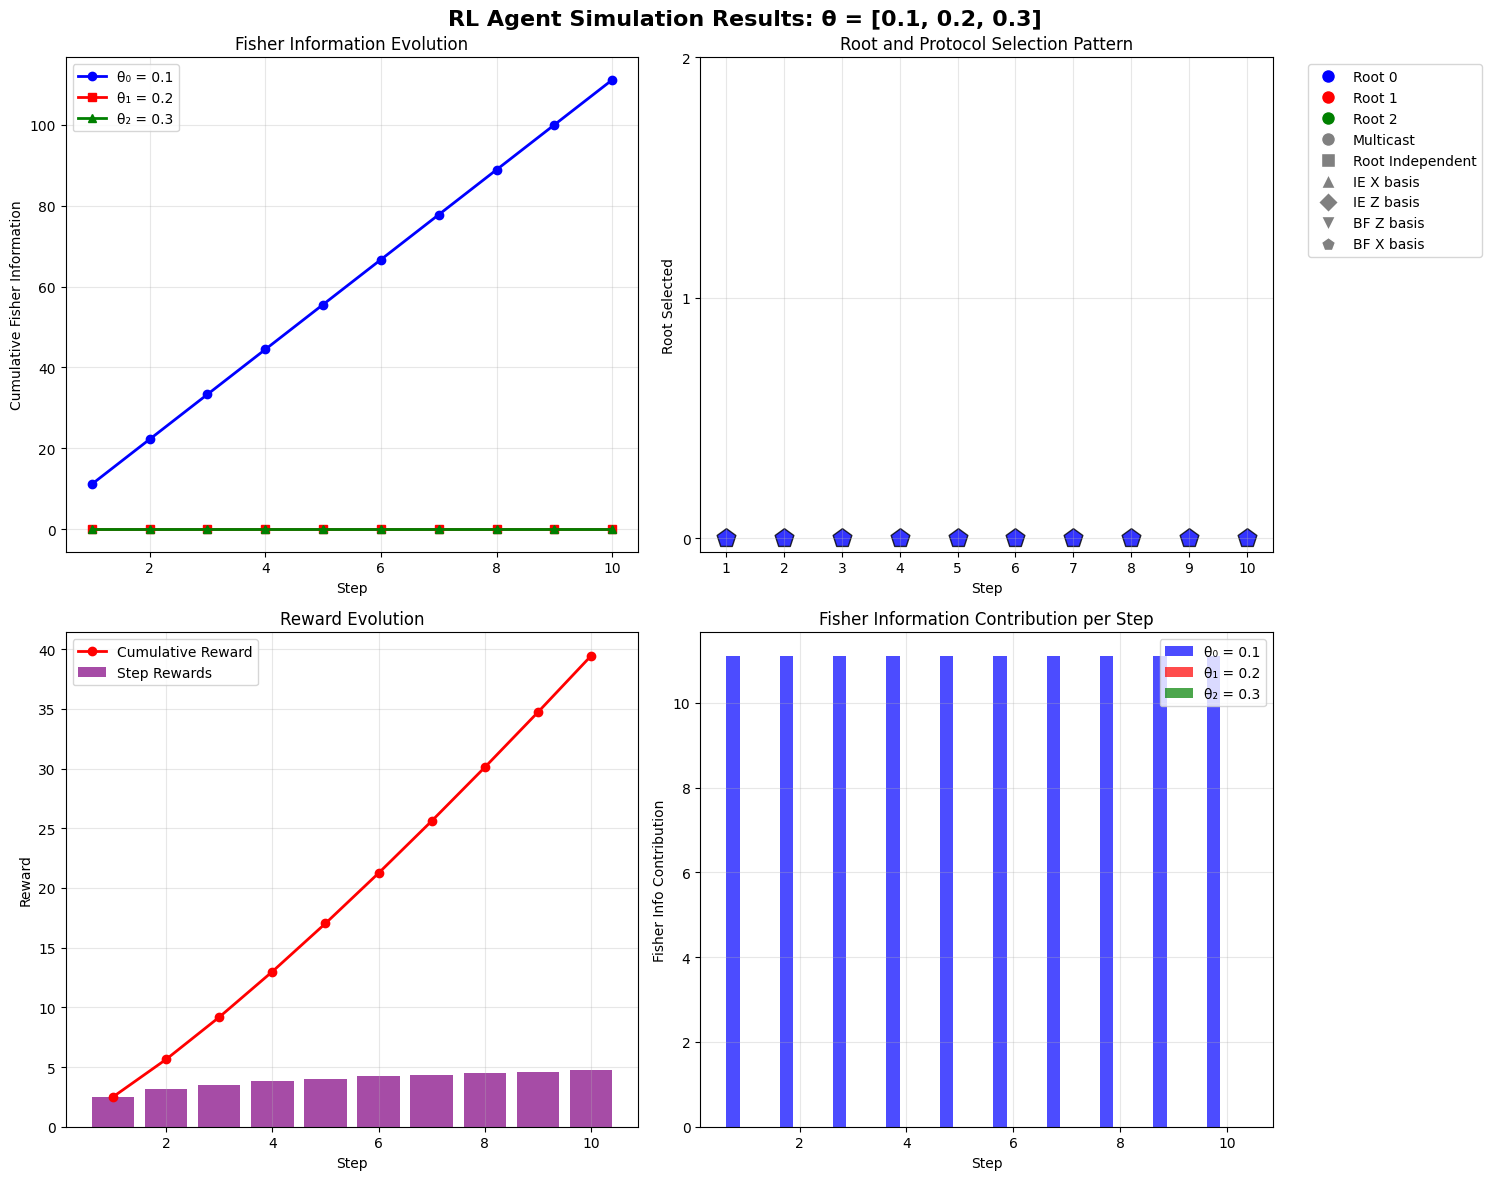


DETAILED ANALYSIS
Balance Score: 0.414 (closer to 1.0 = better balanced)
Efficiency: 11.111 Fisher Info per step
Dominant Root: 0 (used 10/10 times)
Dominant Protocol: 5 (used 10/10 times)

Overall Performance: Fair
The agent could improve balance or efficiency


In [ ]:
# Visualize the simulation results

if trained_model is not None and 'episode_data' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RL Agent Simulation Results: θ = [0.1, 0.2, 0.3]', fontsize=16, fontweight='bold')
    
    # Extract data for plotting
    steps = [data['step'] for data in episode_data]
    rewards = [data['reward'] for data in episode_data]
    cumulative_rewards = [data['total_reward'] for data in episode_data]
    fisher_0 = [np.diag(data['fisher_matrix'])[0] for data in episode_data]
    fisher_1 = [np.diag(data['fisher_matrix'])[1] for data in episode_data]
    fisher_2 = [np.diag(data['fisher_matrix'])[2] for data in episode_data]
    roots = [data['root'] for data in episode_data]
    protocols = [data['protocol'] for data in episode_data]
    
    # Plot 1: Fisher Information Evolution
    ax1 = axes[0, 0]
    ax1.plot(steps, fisher_0, 'o-', label='θ₀ = 0.1', color='blue', linewidth=2, markersize=6)
    ax1.plot(steps, fisher_1, 's-', label='θ₁ = 0.2', color='red', linewidth=2, markersize=6)
    ax1.plot(steps, fisher_2, '^-', label='θ₂ = 0.3', color='green', linewidth=2, markersize=6)
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Cumulative Fisher Information')
    ax1.set_title('Fisher Information Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Action Selection Pattern
    ax2 = axes[0, 1]
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^', 'D', 'v', 'p']
    
    for i, (root, protocol) in enumerate(zip(roots, protocols)):
        ax2.scatter(i+1, root, c=colors[root], s=200, marker=markers[protocol], 
                   alpha=0.8, edgecolors='black', linewidth=1)
    
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Root Selected')
    ax2.set_title('Root and Protocol Selection Pattern')
    ax2.set_yticks([0, 1, 2])
    ax2.set_xticks(range(1, 11))
    ax2.grid(True, alpha=0.3)
    
    protocol_labels = ['Multicast', 'RI', 'IE X basis', 'IE Z basis', 'BF Z basis', 'BF X basis']
    # Create custom legend
    from matplotlib.lines import Line2D
    root_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                         markersize=10, label=f'Root {i}') for i in range(3)]
    protocol_legend = [Line2D([0], [0], marker=markers[i], color='w', markerfacecolor='gray', 
                             markersize=10, label=protocol_labels[i]) for i in range(6)]
    ax2.legend(handles=root_legend + protocol_legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Reward Evolution
    ax3 = axes[1, 0]
    ax3.bar(steps, rewards, alpha=0.7, color='purple', label='Step Rewards')
    ax3.plot(steps, cumulative_rewards, 'ro-', linewidth=2, markersize=6, label='Cumulative Reward')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Reward')
    ax3.set_title('Reward Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Fisher Information Contribution per Step
    ax4 = axes[1, 1]
    fisher_contrib_0 = [np.diag(data['fisher_contribution'])[0] for data in episode_data]
    fisher_contrib_1 = [np.diag(data['fisher_contribution'])[1] for data in episode_data]
    fisher_contrib_2 = [np.diag(data['fisher_contribution'])[2] for data in episode_data]
    
    width = 0.25
    x = np.array(steps)
    ax4.bar(x - width, fisher_contrib_0, width, label='θ₀ = 0.1', color='blue', alpha=0.7)
    ax4.bar(x, fisher_contrib_1, width, label='θ₁ = 0.2', color='red', alpha=0.7)
    ax4.bar(x + width, fisher_contrib_2, width, label='θ₂ = 0.3', color='green', alpha=0.7)
    
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Fisher Info Contribution')
    ax4.set_title('Fisher Information Contribution per Step')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print("\nDETAILED ANALYSIS")
    print("=" * 50)
    
    # Balance assessment
    balance_score = 1 / (1 + cv)  # Higher score = better balance
    print(f"Balance Score: {balance_score:.3f} (closer to 1.0 = better balanced)")
    
    # Efficiency assessment
    total_fisher = np.sum(final_fisher)
    efficiency = total_fisher / 10  # Fisher info per step
    print(f"Efficiency: {efficiency:.3f} Fisher Info per step")
    
    # Strategy assessment
    dominant_root = max(set(roots), key=roots.count)
    dominant_protocol = max(set(protocols), key=protocols.count)
    print(f"Dominant Root: {dominant_root} (used {roots.count(dominant_root)}/10 times)")
    print(f"Dominant Protocol: {dominant_protocol} (used {protocols.count(dominant_protocol)}/10 times)")
    
    # Performance rating
    if balance_score > 0.8 and efficiency > 5.0:
        rating = "Excellent"
    elif balance_score > 0.6 and efficiency > 3.0:
        rating = "Good"
    elif balance_score > 0.4 and efficiency > 1.0:
        rating = "Fair"
    else:
        rating = "Poor"
    
    print(f"\nOverall Performance: {rating}")
    print(f"The agent {'achieved good balance and efficiency' if 'Excellent' in rating or 'Good' in rating else 'could improve balance or efficiency'}")

else:
    print("No simulation data available. Please run the simulation first.")